# Importing required libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

# Data Collection

Data Set Creation using Web Scraping 

In [ ]:
import bs4 as bs
import pandas as pd
from urllib.request import Request, urlopen

df_list = []        #list storing dataframe of past 10 years
r_values = ['210008','200061','190075','180084','170099','160058','150059','140052','130034','120002']         #webpage values for datascraping
csv_files = ['20.csv','19.csv','18.csv','17.csv','16.csv','15.csv','14.csv','13.csv','12.csv','11.csv']        #attaching CSV files from folder

#Scraping data
for i,val in enumerate(r_values):
    url = 'https://sofifa.com/teams?lg=13&r='+val+'&set=true'
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

    webpage = urlopen(req).read()

    webpage = bs.BeautifulSoup(webpage,'lxml')

    table=webpage.find('table')
    table_rows=table.find_all('tr')

    info=[]
    for tr in table_rows:
        td=tr.find_all('td')
        row=[i.text.strip() for i in td]
        info.append(row)
    
    td = table.find_all("div",{"class":"bp3-text-overflow-ellipsis"})
    Names = []
    for idx,data in enumerate(td):
        if idx%2 == 0:
            Names.append(data.text)

    df = pd.DataFrame(info)

    df=df.drop([0,1],axis=1)
    df=df.drop([0],axis=0)

    df['Team']=Names

    res=pd.read_csv(csv_files[i])

    teamsset = set(res["HomeTeam"].tolist())
    teamsset = list(teamsset)
    Names.sort()
    
    teamsset_cleaned = [x for x in teamsset if str(x) != 'nan']

    teamsset_cleaned.sort()
    
    #the team names in csv are shortened team names whereas those on webpage are actual team names
    #inorder to merge the teams data correctly we create a dictionary of shortened team names corresponding to the actual ones
    #we replace the team names derived from csv to the actual names correspondingly
    dictionary = dict(zip(Names,teamsset_cleaned))
    
    teamslist = df["Team"].tolist()

    for index,teams in enumerate(teamslist):
        teamslist[index] = dictionary[teams]
    
    df["Team"] = teamslist
    
    df_home=df.copy()
    df_away=df.copy()     
    #adding the names of the newly added features after scraping
    df_home.columns=['Home_OVA','Home_ATT','Home_MID','Home_DEF','Home_TRANSFER','Home_PLAYERS','Home_HITS','HomeTeam']
    df_away.columns=['Away_OVA','Away_ATT','Away_MID','Away_DEF','Away_TRANSFER','Away_PLAYERS','Away_HITS','AwayTeam']

    #merging the dataset with the scraped data
    res=pd.merge(res,df_home,on="HomeTeam",how="left")
    res=pd.merge(res,df_away,on="AwayTeam",how="left")
    
    #removing unwanted features like referee names, team names, betting odds
    res = res[['HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','Home_OVA','Home_ATT','Home_MID','Home_DEF','Home_TRANSFER','Home_PLAYERS','Home_HITS','Away_OVA','Away_ATT','Away_MID','Away_DEF','Away_TRANSFER','Away_PLAYERS','Away_HITS','FTR']]
    
    df_list.append(res)
    print("Dataframe made for year: 20"+str(20-i)+"-20"+str(20-i+1))     #success message after receiving the dataset in our list

Dataframe made for year: 2020-2021
Dataframe made for year: 2019-2020
Dataframe made for year: 2018-2019
Dataframe made for year: 2017-2018
Dataframe made for year: 2016-2017
Dataframe made for year: 2015-2016
Dataframe made for year: 2014-2015
Dataframe made for year: 2013-2014
Dataframe made for year: 2012-2013
Dataframe made for year: 2011-2012


In [ ]:
df = pd.DataFrame()
for i in df_list:
    df = pd.concat([df,i], ignore_index=True)
df

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Home_OVA,Home_ATT,Home_MID,Home_DEF,Home_TRANSFER,Home_PLAYERS,Home_HITS,Away_OVA,Away_ATT,Away_MID,Away_DEF,Away_TRANSFER,Away_PLAYERS,Away_HITS,FTR
0,0.0,1.0,5.0,13.0,2.0,6.0,12.0,12.0,2.0,3.0,2.0,2.0,0.0,0.0,75,77,74,73,€16.5M,33,309,80,84,81,77,€80M,32,1.2K,A
1,1.0,0.0,5.0,9.0,3.0,5.0,14.0,11.0,7.0,3.0,2.0,1.0,0.0,0.0,77,79,76,74,€30M,33,245,76,77,76,76,€35M,28,343,H
2,3.0,2.0,22.0,6.0,6.0,3.0,9.0,6.0,9.0,0.0,1.0,0.0,0.0,0.0,85,89,84,86,€90M,32,1.1K,74,77,75,74,€16.5M,33,661,H
3,0.0,0.0,15.0,15.0,3.0,2.0,13.0,7.0,8.0,7.0,2.0,2.0,0.0,0.0,78,79,78,77,€35M,33,348,77,76,77,76,€30M,33,403,A
4,0.0,0.0,7.0,13.0,1.0,7.0,12.0,9.0,2.0,5.0,1.0,1.0,0.0,0.0,73,72,73,73,€18.4M,30,222,79,81,79,79,€45M,31,593,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,0.0,1.0,6.0,17.0,5.0,9.0,14.0,11.0,1.0,9.0,3.0,3.0,0.0,0.0,76,66,73,70,€16M,33,299,83,78,76,77,€33M,33,1.6K,A
3485,0.0,0.0,13.0,14.0,8.0,9.0,5.0,5.0,6.0,5.0,1.0,1.0,0.0,0.0,73,70,68,66,€7M,33,187,81,75,71,73,€26M,33,1.1K,H
3486,1.0,0.0,15.0,10.0,9.0,7.0,8.0,12.0,9.0,3.0,0.0,2.0,0.0,0.0,81,73,75,77,€22M,33,826,77,74,68,73,€14M,33,309,H
3487,2.0,2.0,12.0,12.0,8.0,8.0,12.0,10.0,9.0,5.0,0.0,1.0,0.0,0.0,74,70,67,69,€8M,33,222,81,78,73,76,€30M,33,1.2K,A


## Data Preprocessing

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)
df

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Home_OVA,Home_ATT,Home_MID,Home_DEF,Home_TRANSFER,Home_PLAYERS,Home_HITS,Away_OVA,Away_ATT,Away_MID,Away_DEF,Away_TRANSFER,Away_PLAYERS,Away_HITS,FTR
0,0.0,1.0,5.0,13.0,2.0,6.0,12.0,12.0,2.0,3.0,2.0,2.0,0.0,0.0,75,77,74,73,€16.5M,33,225,80,84,81,77,€80M,32,855,A
1,1.0,0.0,5.0,9.0,3.0,5.0,14.0,11.0,7.0,3.0,2.0,1.0,0.0,0.0,77,79,76,74,€30M,33,186,76,77,76,76,€35M,28,241,H
2,3.0,2.0,22.0,6.0,6.0,3.0,9.0,6.0,9.0,0.0,1.0,0.0,0.0,0.0,85,89,84,86,€90M,32,763,74,77,75,74,€16.5M,33,446,H
3,0.0,0.0,15.0,15.0,3.0,2.0,13.0,7.0,8.0,7.0,2.0,2.0,0.0,0.0,78,79,78,77,€35M,33,230,77,76,77,76,€30M,33,284,A
4,0.0,0.0,7.0,13.0,1.0,7.0,12.0,9.0,2.0,5.0,1.0,1.0,0.0,0.0,73,72,73,73,€18.4M,30,168,79,81,79,79,€45M,31,410,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,0.0,1.0,6.0,17.0,5.0,9.0,14.0,11.0,1.0,9.0,3.0,3.0,0.0,0.0,76,66,73,70,€16M,33,209,83,78,76,77,€33M,33,1.2K,A
3484,0.0,0.0,13.0,14.0,8.0,9.0,5.0,5.0,6.0,5.0,1.0,1.0,0.0,0.0,73,70,68,66,€7M,33,136,81,75,71,73,€26M,33,765,H
3485,1.0,0.0,15.0,10.0,9.0,7.0,8.0,12.0,9.0,3.0,0.0,2.0,0.0,0.0,81,73,75,77,€22M,33,586,77,74,68,73,€14M,33,225,H
3486,2.0,2.0,12.0,12.0,8.0,8.0,12.0,10.0,9.0,5.0,0.0,1.0,0.0,0.0,74,70,67,69,€8M,33,168,81,78,73,76,€30M,33,855,A


Encoding Categorical Variables

In [ ]:
def categorize_victory(x):
    if x=='A':
        return 0
    if x=='D':
        return 1
    if x=='H':
        return 2

In [ ]:
df['FTR'] = df['FTR'].apply(categorize_victory)
df

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Home_OVA,Home_ATT,Home_MID,Home_DEF,Home_TRANSFER,Home_PLAYERS,Home_HITS,Away_OVA,Away_ATT,Away_MID,Away_DEF,Away_TRANSFER,Away_PLAYERS,Away_HITS,FTR
0,0.0,1.0,5.0,13.0,2.0,6.0,12.0,12.0,2.0,3.0,2.0,2.0,0.0,0.0,75,77,74,73,€16.5M,33,225,80,84,81,77,€80M,32,855,0
1,1.0,0.0,5.0,9.0,3.0,5.0,14.0,11.0,7.0,3.0,2.0,1.0,0.0,0.0,77,79,76,74,€30M,33,186,76,77,76,76,€35M,28,241,2
2,3.0,2.0,22.0,6.0,6.0,3.0,9.0,6.0,9.0,0.0,1.0,0.0,0.0,0.0,85,89,84,86,€90M,32,763,74,77,75,74,€16.5M,33,446,2
3,0.0,0.0,15.0,15.0,3.0,2.0,13.0,7.0,8.0,7.0,2.0,2.0,0.0,0.0,78,79,78,77,€35M,33,230,77,76,77,76,€30M,33,284,0
4,0.0,0.0,7.0,13.0,1.0,7.0,12.0,9.0,2.0,5.0,1.0,1.0,0.0,0.0,73,72,73,73,€18.4M,30,168,79,81,79,79,€45M,31,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,0.0,1.0,6.0,17.0,5.0,9.0,14.0,11.0,1.0,9.0,3.0,3.0,0.0,0.0,76,66,73,70,€16M,33,209,83,78,76,77,€33M,33,1.2K,0
3484,0.0,0.0,13.0,14.0,8.0,9.0,5.0,5.0,6.0,5.0,1.0,1.0,0.0,0.0,73,70,68,66,€7M,33,136,81,75,71,73,€26M,33,765,2
3485,1.0,0.0,15.0,10.0,9.0,7.0,8.0,12.0,9.0,3.0,0.0,2.0,0.0,0.0,81,73,75,77,€22M,33,586,77,74,68,73,€14M,33,225,2
3486,2.0,2.0,12.0,12.0,8.0,8.0,12.0,10.0,9.0,5.0,0.0,1.0,0.0,0.0,74,70,67,69,€8M,33,168,81,78,73,76,€30M,33,855,0


In [ ]:
def trim(x):
    x=str(x)
    return x[1:len(x)-1]

In [ ]:
df['Home_TRANSFER'] = df['Home_TRANSFER'].apply(trim)
df['Away_TRANSFER'] = df['Away_TRANSFER'].apply(trim)

In [ ]:
def value_to_float(x):
    x=str(x)
    if 'K' in x:
        return (float(x.replace('K', '')) * 1000)
    return (x)

In [ ]:
df['Home_HITS'] = df['Home_HITS'].apply(value_to_float)
df['Away_HITS'] = df['Away_HITS'].apply(value_to_float)

In [ ]:
df['Home_OVA'] = pd.to_numeric(df['Home_OVA'])
df['Home_ATT'] = pd.to_numeric(df['Home_ATT'])
df['Home_DEF'] = pd.to_numeric(df['Home_DEF'])
df['Home_MID'] = pd.to_numeric(df['Home_MID'])
df['Home_TRANSFER'] = pd.to_numeric(df['Home_TRANSFER'])
df['Home_PLAYERS'] = pd.to_numeric(df['Home_PLAYERS'])
df['Home_HITS'] = pd.to_numeric(df['Home_HITS'])
df['Away_OVA'] = pd.to_numeric(df['Away_OVA'])
df['Away_ATT'] = pd.to_numeric(df['Away_ATT'])
df['Away_DEF'] = pd.to_numeric(df['Away_DEF'])
df['Away_MID'] = pd.to_numeric(df['Away_MID'])
df['Away_TRANSFER'] = pd.to_numeric(df['Away_TRANSFER'])
df['Away_PLAYERS'] = pd.to_numeric(df['Away_PLAYERS'])
df['Away_HITS'] = pd.to_numeric(df['Away_HITS'])

## Feature Selection

Feature Selection using Chi-squared as scoring function


In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.iloc[:,0:28]
#X = df_list[0].iloc[:,np.r_[1:16, 98:]]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

            Specs         Score
20      Home_HITS  66927.962980
27      Away_HITS  64655.287169
18  Home_TRANSFER   5008.465388
25  Away_TRANSFER   4536.819174
4             HST    784.363470
1            HTAG    766.110299
5             AST    763.135028
0            HTHG    728.699961
3              AS    517.389894
2              HS    424.531037
12             HR     73.109505
16       Home_MID     53.742182
15       Home_ATT     50.751771
10             HY     48.674467
23       Away_MID     47.082989
14       Home_OVA     46.444268
22       Away_ATT     44.955740
17       Home_DEF     43.585301
21       Away_OVA     41.217297
24       Away_DEF     40.025042


Feature Selection using F-Classif as scoring function


(Tried but Chi^2 is giving better results) 

In [ ]:
# import numpy as np
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# X = df.iloc[:,0:28]
# #X = df_list[0].iloc[:,np.r_[1:16, 98:]]  #independent columns
# y = df.iloc[:,-1]    #target column i.e price range
# #apply SelectKBest class to extract top 10 best features
# bestfeatures = SelectKBest(score_func=f_classif, k=10)
# fit = bestfeatures.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(20,'Score'))  #print 10 best features

Correlation Matrix 

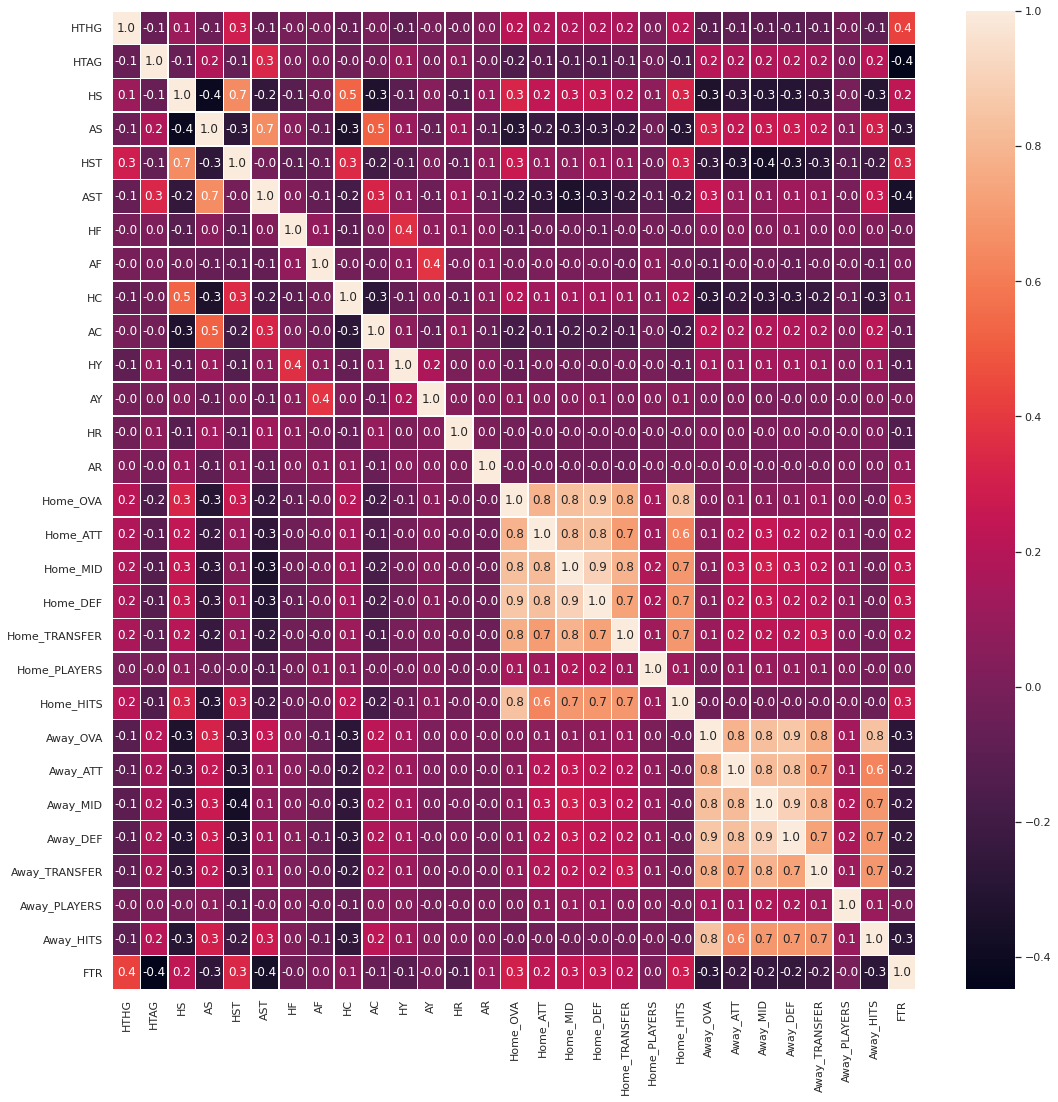

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
df

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Home_OVA,Home_ATT,Home_MID,Home_DEF,Home_TRANSFER,Home_PLAYERS,Home_HITS,Away_OVA,Away_ATT,Away_MID,Away_DEF,Away_TRANSFER,Away_PLAYERS,Away_HITS,FTR
0,0.0,1.0,5.0,13.0,2.0,6.0,12.0,12.0,2.0,3.0,2.0,2.0,0.0,0.0,75,77,74,73,16.5,33,225.0,80,84,81,77,80.0,32,855.0,0
1,1.0,0.0,5.0,9.0,3.0,5.0,14.0,11.0,7.0,3.0,2.0,1.0,0.0,0.0,77,79,76,74,30.0,33,186.0,76,77,76,76,35.0,28,241.0,2
2,3.0,2.0,22.0,6.0,6.0,3.0,9.0,6.0,9.0,0.0,1.0,0.0,0.0,0.0,85,89,84,86,90.0,32,763.0,74,77,75,74,16.5,33,446.0,2
3,0.0,0.0,15.0,15.0,3.0,2.0,13.0,7.0,8.0,7.0,2.0,2.0,0.0,0.0,78,79,78,77,35.0,33,230.0,77,76,77,76,30.0,33,284.0,0
4,0.0,0.0,7.0,13.0,1.0,7.0,12.0,9.0,2.0,5.0,1.0,1.0,0.0,0.0,73,72,73,73,18.4,30,168.0,79,81,79,79,45.0,31,410.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,0.0,1.0,6.0,17.0,5.0,9.0,14.0,11.0,1.0,9.0,3.0,3.0,0.0,0.0,76,66,73,70,16.0,33,209.0,83,78,76,77,33.0,33,1200.0,0
3484,0.0,0.0,13.0,14.0,8.0,9.0,5.0,5.0,6.0,5.0,1.0,1.0,0.0,0.0,73,70,68,66,7.0,33,136.0,81,75,71,73,26.0,33,765.0,2
3485,1.0,0.0,15.0,10.0,9.0,7.0,8.0,12.0,9.0,3.0,0.0,2.0,0.0,0.0,81,73,75,77,22.0,33,586.0,77,74,68,73,14.0,33,225.0,2
3486,2.0,2.0,12.0,12.0,8.0,8.0,12.0,10.0,9.0,5.0,0.0,1.0,0.0,0.0,74,70,67,69,8.0,33,168.0,81,78,73,76,30.0,33,855.0,0


Reduced Dataset obtained using Chi^2 K_Best Feature Selection

In [ ]:
reduced_df = df[['Home_HITS','Away_HITS','Home_TRANSFER','Away_TRANSFER','HST','HTAG','AST','HTHG','AS','HS']]

In [ ]:
X=reduced_df

Train_Test_Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Scaling using MinMaxScalar

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Value Counts

In [ ]:
y.value_counts()

2    1582
0    1068
1     838
Name: FTR, dtype: int64

Count Plot

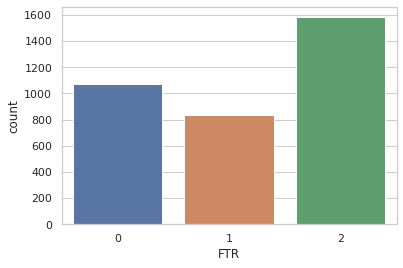

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='FTR', data=df)

Pair Plot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


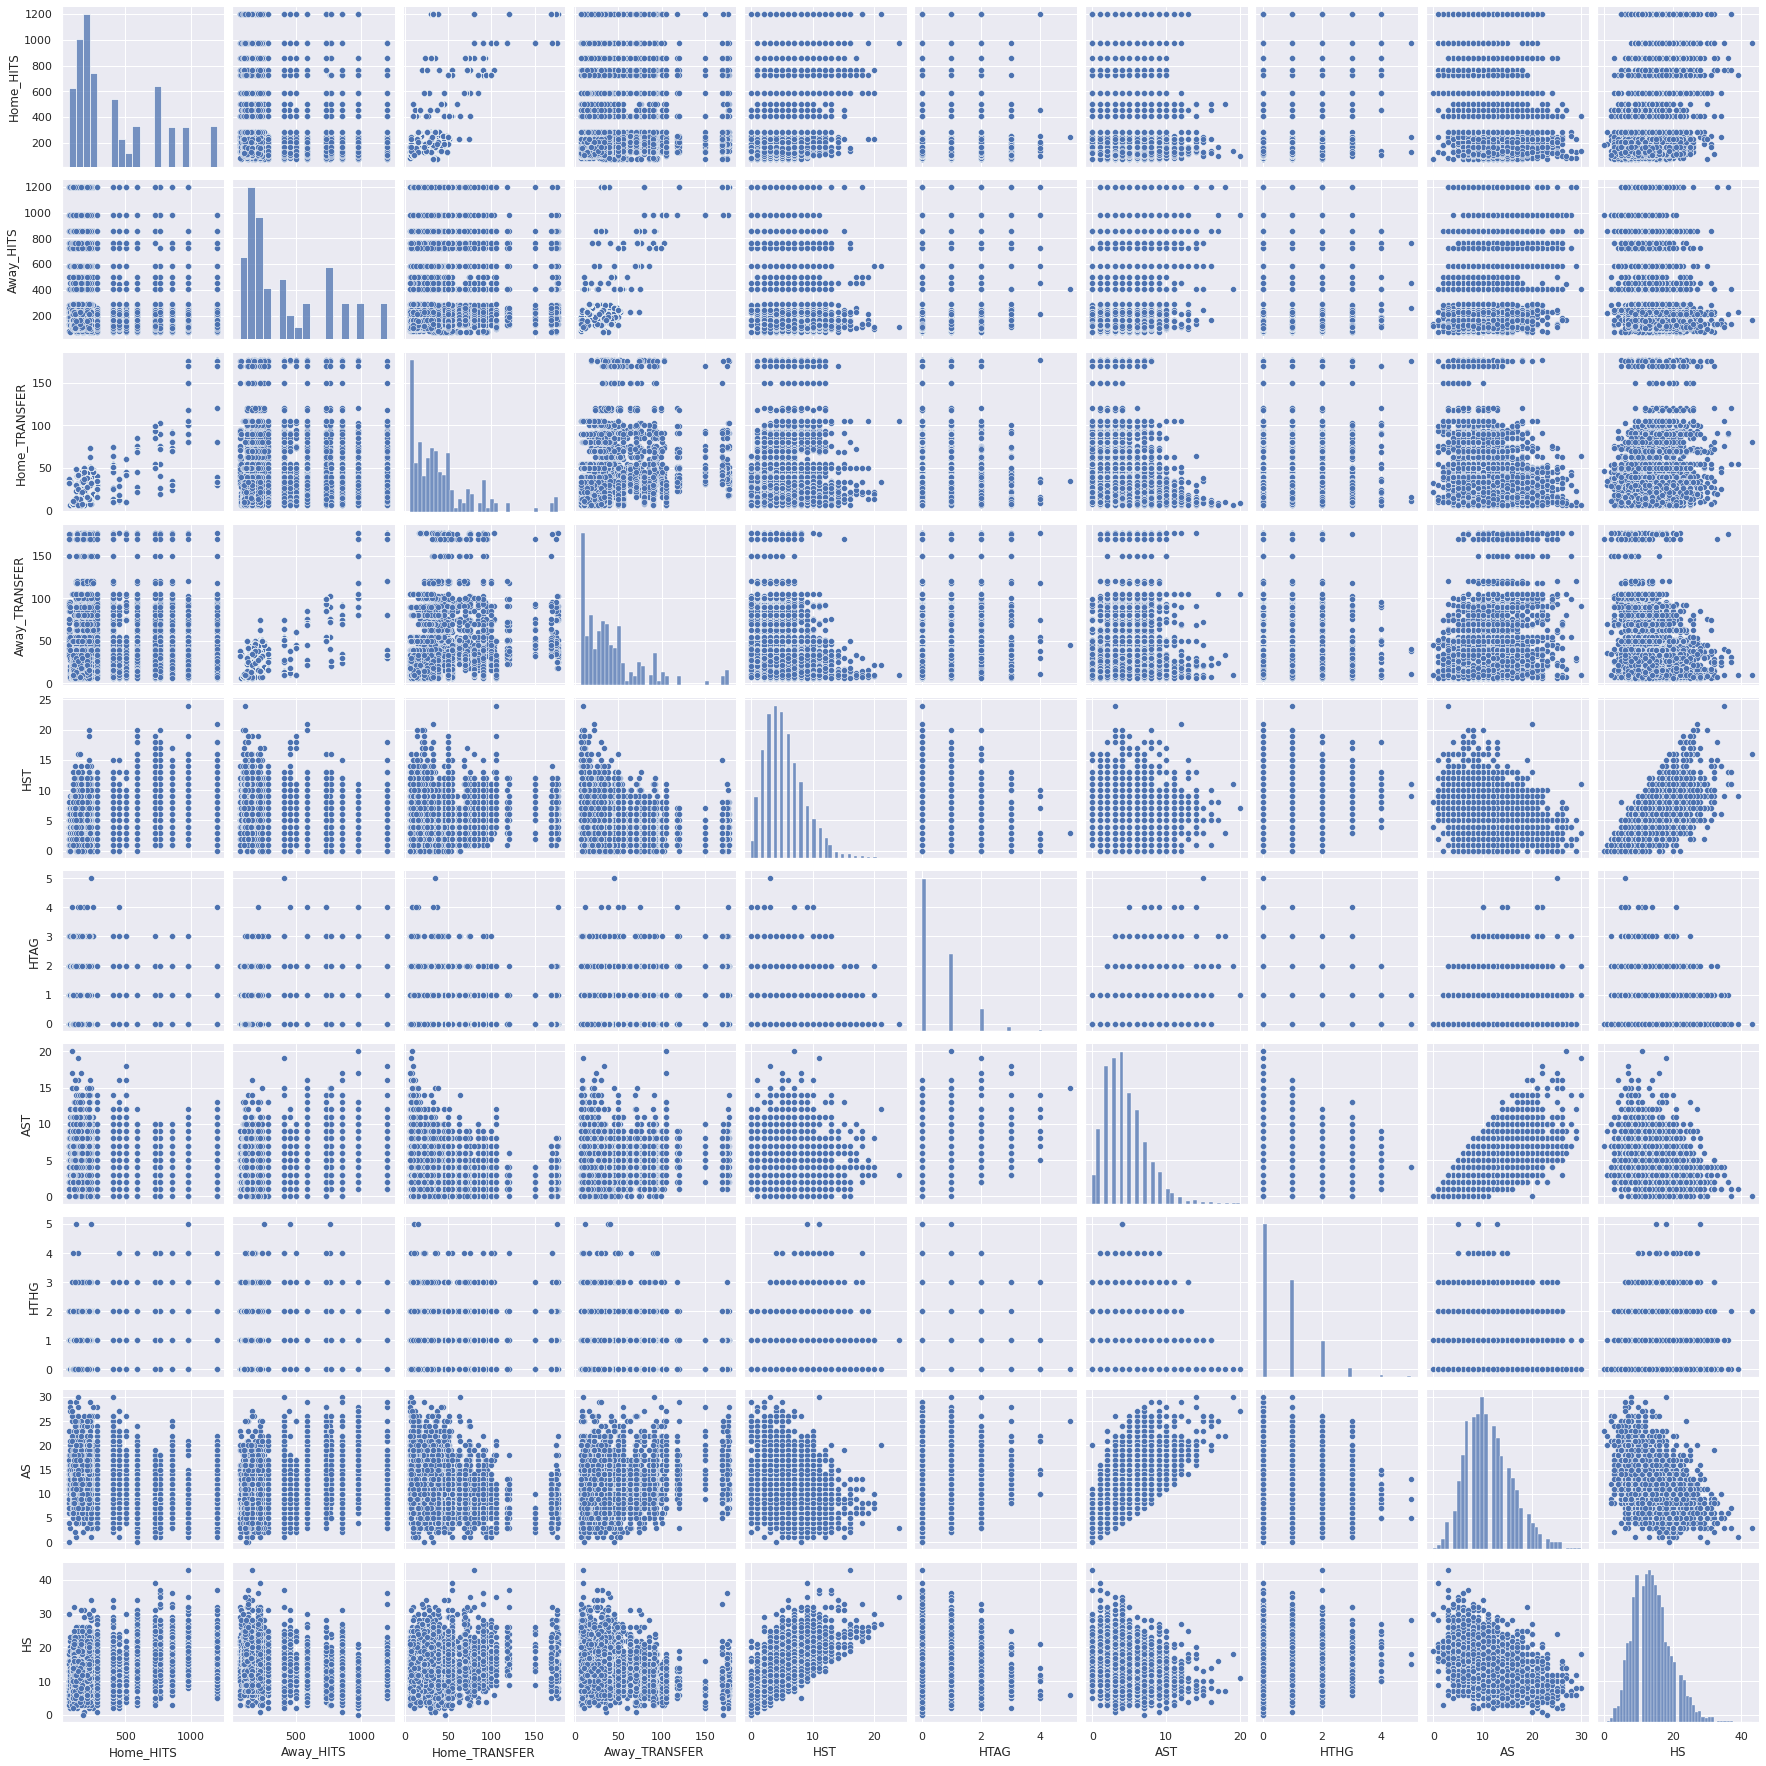

In [ ]:
#scatterplot
sns.set()
sns.pairplot(reduced_df, size = 2.5)
plt.show();

#Logistic Regression



Logistic Regression without hyper-parameter tuning


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'lbfgs',multi_class='multinomial',max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics
LR_accuracy = metrics.accuracy_score(y_test, y_pred)
LR_accuracy


0.6432664756446992

Hyper-tuning Logistic Regression using Grid Search

In [ ]:
#GRID_SEARCH ON LR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=2000)
grid={"C":[0.1,0.01,0.001], "penalty":["l1","l2"], "solver":['lbfgs','newton-cg','sagsaga'],"multi_class":['multinomial']}
LR_CV = GridSearchCV(LR, param_grid=grid, n_jobs=-1, verbose=3, cv = 5)
LR_CV.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.01, 0.001],
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'sagsaga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
LR_CV.best_params_

{'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
from sklearn.metrics import plot_confusion_matrix

Logistic Regression after Hyper-parameter Tuning

Accuracy:  0.6532951289398281
              precision    recall  f1-score   support

           0       0.67      0.77      0.71       223
           1       0.36      0.03      0.06       156
           2       0.66      0.88      0.75       319

    accuracy                           0.65       698
   macro avg       0.56      0.56      0.51       698
weighted avg       0.59      0.65      0.58       698

Confusion Matrix:



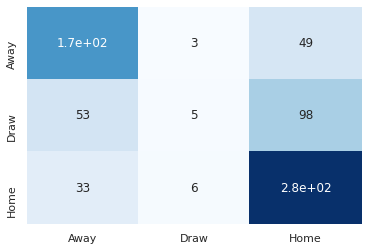

In [ ]:
y_pred = LR_CV.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
LR_GS_accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy_score(y_test,y_pred))

print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

#Gaussian NB

Gaussian Naive Bayes without hyper-parameter tuning


Accuracy:  0.6260744985673352
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       223
           1       0.37      0.37      0.37       156
           2       0.73      0.71      0.72       319

    accuracy                           0.63       698
   macro avg       0.59      0.59      0.59       698
weighted avg       0.63      0.63      0.63       698

Confusion Matrix:



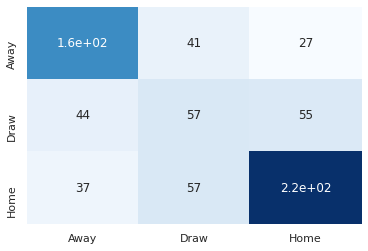

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
nb_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
NB_accuracy = accuracy_score(y_test,nb_pred)
print("Accuracy: ",accuracy_score(y_test,nb_pred))
print(classification_report(y_test,nb_pred))
cm = confusion_matrix(y_test,nb_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

Hyper-tuning Gaussian Naive Bayes using Grid Search

In [ ]:
#With GridSearch
from sklearn.model_selection import GridSearchCV
NB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(NB,parameters,cv=5,verbose=5,scoring='accuracy')
gs_NB.fit(X_train,y_train)
gsnb_pred = model.predict(X_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.584, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.604, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.615, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.609, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.602, total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_smoothing=0.8111308307896871, score=0.599, total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] ... var_smoothing=0.08111308307896872, score=0.613, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.659, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.593, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.634, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .... var_smoothing=0.0657933224657568, score=0.606, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .... var_smoothing=0.0657933224657568, score=0.613, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .... var_smoothing=0.0657933224657568, score=0.658, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


Gaussian Naive Bayes after Hyper-parameter Tuning

Accuracy:  0.6260744985673352
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       223
           1       0.37      0.37      0.37       156
           2       0.73      0.71      0.72       319

    accuracy                           0.63       698
   macro avg       0.59      0.59      0.59       698
weighted avg       0.63      0.63      0.63       698

Confusion Matrix:



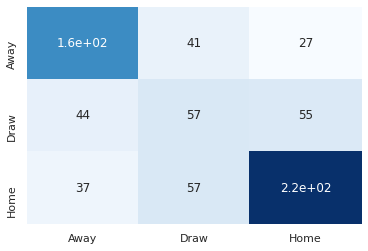

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
NB_GS_accuracy = accuracy_score(y_test,gsnb_pred)
print("Accuracy: ", accuracy_score(y_test,gsnb_pred))
print(classification_report(y_test,gsnb_pred))

cm = confusion_matrix(y_test,gsnb_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

#SVC

Support Vector Classifier without Hyper-parameter tuning

In [ ]:
 # "Support vector classifier"
from sklearn.svm import SVC
model = SVC(kernel = 'linear', C = 1,decision_function_shape='ovo')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics
SVM_accuracy = metrics.accuracy_score(y_test, y_pred)
SVM_accuracy
# 0.6504297994269341

0.6590257879656161

Hyper-tuning Support Vector Classifier with Grid Search

In [ ]:
#Using GSCV on SVC
from sklearn.model_selection import GridSearchCV
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# parameters = {'max_leaf_nodes': list(range(2, 100)),
#           'min_samples_split': [2, 3, 4]}
svc = SVC(kernel = 'linear', C = 1,decision_function_shape='ovo')
model = GridSearchCV(svc, parameters, cv=5, scoring = 'accuracy', verbose=50, n_jobs=-1)
model.fit(X_train,y_train)
model.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

SVC after Hyper-parameter tuning

Accuracy:  0.66189111747851
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.72      0.70       223
           1       0.41      0.26      0.32       156
           2       0.72      0.82      0.77       319

    accuracy                           0.66       698
   macro avg       0.60      0.60      0.59       698
weighted avg       0.64      0.66      0.64       698

Confusion Matrix:



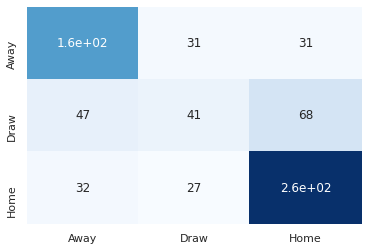

In [ ]:
svc_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
SVM_GS_accuracy = accuracy_score(y_test,svc_pred)
print("Accuracy: ", accuracy_score(y_test,svc_pred))
print("Classification Report: \n",classification_report(y_test,svc_pred))
cm = confusion_matrix(y_test,svc_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

#Decision Tree

Decision Tree without hyper-parameter tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_pred = model.predict(X_test)


Accuracy:  0.6117478510028653
              precision    recall  f1-score   support

           0       0.53      0.82      0.65       223
           1       0.00      0.00      0.00       156
           2       0.69      0.77      0.72       319

    accuracy                           0.61       698
   macro avg       0.41      0.53      0.46       698
weighted avg       0.48      0.61      0.54       698

Confusion Matrix:



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


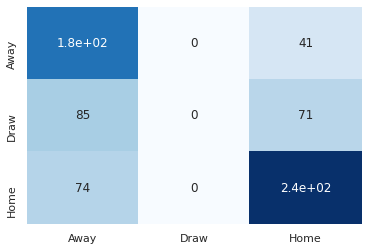

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
DT_accuracy = accuracy_score(y_test,dt_pred)
print("Accuracy: ",accuracy_score(y_test,dt_pred))
print(classification_report(y_test,dt_pred))
cm = confusion_matrix(y_test,dt_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

Hypertuning Decision Tree using Grid Search

In [ ]:
#GS
from sklearn.model_selection import GridSearchCV
parameters = {'criterion': ['entropy','gini'], 
            'min_samples_split' : range(10,500,20),
            'max_depth': range(1,20,2)}

# parameters = {'max_leaf_nodes': list(range(2, 100)),
#           'min_samples_split': [2, 3, 4]}
dt = DecisionTreeClassifier()  
model = GridSearchCV(dt, parameters, cv=5, scoring = 'accuracy', verbose=50, n_jobs=-1)
model.fit(X_train,y_train)
model.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0509s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0254s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0436s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 150}

Decision Tree after Hyper-parameter tuning 

Accuracy:  0.5959885386819485
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       223
           1       0.30      0.33      0.32       156
           2       0.72      0.72      0.72       319

    accuracy                           0.60       698
   macro avg       0.56      0.55      0.55       698
weighted avg       0.60      0.60      0.60       698

Confusion Matrix:



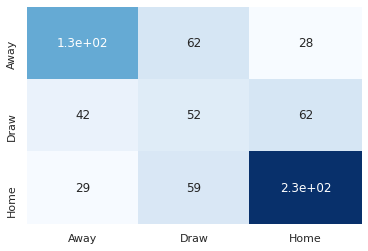

In [ ]:
gsdt_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
DT_GS_accuracy = accuracy_score(y_test,gsdt_pred)
print("Accuracy: ",accuracy_score(y_test,gsdt_pred))
print(classification_report(y_test,gsdt_pred))
cm = confusion_matrix(y_test,gsdt_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

# RFC

Random Forest without hyper-parameter tuning 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfnew = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfnew.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy:  0.6547277936962751
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       223
           1       0.40      0.22      0.29       156
           2       0.71      0.82      0.76       319

    accuracy                           0.65       698
   macro avg       0.59      0.59      0.58       698
weighted avg       0.63      0.65      0.63       698

Confusion Matrix:



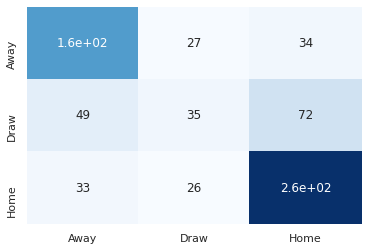

In [ ]:
rfnew_pred = rfnew.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print("Accuracy: ",accuracy_score(y_test,rfnew_pred))
print(classification_report(y_test,rfnew_pred))
cm = confusion_matrix(y_test,rfnew_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

Hyper-tuning Random Forest using Grid Search

In [ ]:

#With Grid Search
from sklearn.model_selection import GridSearchCV
parameters = { 
    'n_estimators': [200,500],
    'max_depth' : [8,20,50],
    'min_samples_leaf':[1,2,4],
    'min_samples_split':[2,10],
    'criterion' :['gini', 'entropy']
}


rf = RandomForestClassifier(max_features='auto')
model = GridSearchCV(rf, parameters, cv=5, scoring = 'accuracy', verbose=5, n_jobs=-1)
model.fit(X_train,y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Random Forest after Hyper-parameter Tuning

Accuracy:  0.6561604584527221
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       223
           1       0.39      0.23      0.29       156
           2       0.71      0.82      0.76       319

    accuracy                           0.66       698
   macro avg       0.59      0.59      0.58       698
weighted avg       0.63      0.66      0.64       698

Confusion Matrix:



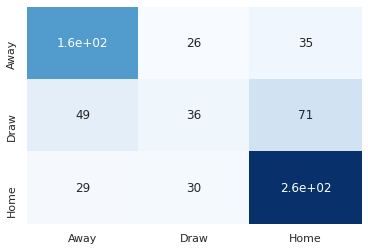

In [ ]:
rf_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
RF_GS_accuracy = accuracy_score(y_test,rf_pred)
print("Accuracy: ",accuracy_score(y_test,rf_pred))
print(classification_report(y_test,rf_pred))
cm = confusion_matrix(y_test,rf_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

Accuracy:  0.6590257879656161
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       223
           1       0.43      0.21      0.28       156
           2       0.70      0.83      0.76       319

    accuracy                           0.66       698
   macro avg       0.60      0.59      0.58       698
weighted avg       0.63      0.66      0.63       698

Confusion Matrix:



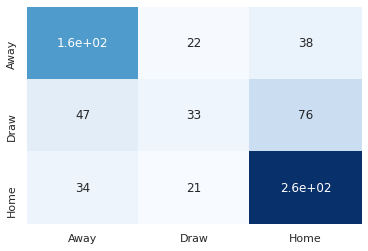

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfnew = RandomForestClassifier(
  max_depth=8,
 min_samples_leaf= 4,
 min_samples_split=10,
 n_estimators=500,
 criterion='entropy'
)
rfnew.fit(X_train,y_train)
rf_pred = rfnew.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
RF_GS_accuracy = accuracy_score(y_test,rf_pred)
print("Accuracy: ",accuracy_score(y_test,rf_pred))
print(classification_report(y_test,rf_pred))
cm = confusion_matrix(y_test,rf_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

# MLPClassifier

MLP Classifier without Hyper-parameter Tuning

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='sgd')
mlp.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy:  0.6418338108882522
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       223
           1       0.36      0.03      0.05       156
           2       0.65      0.86      0.74       319

    accuracy                           0.64       698
   macro avg       0.55      0.55      0.49       698
weighted avg       0.58      0.64      0.57       698

Confusion Matrix:



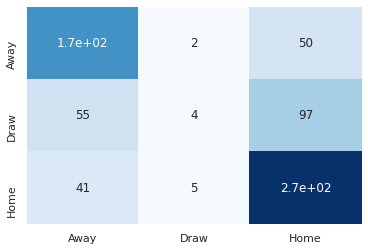

In [ ]:
mlp_pred = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print("Accuracy: ",accuracy_score(y_test,mlp_pred))
MLP_accuracy = accuracy_score(y_test,mlp_pred)
print(classification_report(y_test,mlp_pred))
cm = confusion_matrix(y_test,mlp_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

Hypertuning MLP with Grid Search

In [166]:
#GS
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp_gs = MLPClassifier(max_iter=1000)
parameters = {
    'hidden_layer_sizes': [(100,50,100),(100,)],
    'activation': ['tanh', 'relu','softmax'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

model = GridSearchCV(mlp_gs, parameters, n_jobs=-1, cv=5, verbose=5,scoring='accuracy')
model.fit(X_train, y_train)




Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   58.1s


KeyboardInterrupt: ignored

In [ ]:
model.best_params_

MLP Classifier after Grid Search 

Accuracy:  0.6475644699140402
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       223
           1       0.33      0.17      0.22       156
           2       0.71      0.82      0.76       319

    accuracy                           0.65       698
   macro avg       0.56      0.57      0.56       698
weighted avg       0.61      0.65      0.62       698

Confusion Matrix:



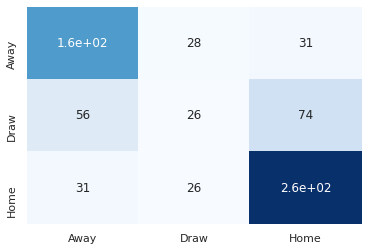

In [ ]:
mlpgs_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print("Accuracy: ",accuracy_score(y_test,mlpgs_pred))
MLP_GS_accuracy = accuracy_score(y_test,mlpgs_pred)
print(classification_report(y_test,mlpgs_pred))
cm = confusion_matrix(y_test,mlpgs_pred)
print("Confusion Matrix:\n")
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False,xticklabels=['Away','Draw','Home'],yticklabels=['Away','Draw','Home'])

In [ ]:
# #Nooral Network
# from keras.models import Sequential 
# from keras.layers import Dense 
# from keras.utils import np_utils
# from sklearn.preprocessing import LabelEncoder
# from keras.utils.np_utils import to_categorical
# from sklearn.utils import shuffle

In [ ]:
#https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa

#Neural Network

In [ ]:
# encoder = LabelEncoder()
# encoder.fit(y_train)
# encoded_Y = encoder.transform(y_train)
# encoded_Y

In [ ]:
# dummy_y = np_utils.to_categorical(encoded_Y)
# dummy_y

In [ ]:
# dummy_y.shape

In [ ]:
# y_test = np_utils.to_categorical(y_test)

In [ ]:
# from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# input_dim = len(X.columns)
# model = Sequential()
# model.add(Dense(100, input_dim = input_dim, activation = 'relu'))
# model.add(Dense(50, activation = 'relu'))
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(3, activation = 'softmax'))

# model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'] )

# model.fit(X_train,dummy_y, epochs = 500, batch_size =1000)
# # kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# # results = cross_val_score(model,X_train,dummy_y,cv=kfold, scoring='accuracy')
# # print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# scores = model.evaluate(X_test,y_test)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [ ]:
models_sfm = pd.DataFrame({
    'Model'       : ['Logistic Regression','GaussianNB','Support Vector Machine','Decision Tree','Random Forest','MLPClassifier'],
    'Accuracy'    : [LR_GS_accuracy, NB_GS_accuracy, SVM_GS_accuracy, DT_GS_accuracy, RF_GS_accuracy,MLP_GS_accuracy],
    
    }, columns = ['Model', 'Accuracy'])

print(models_sfm.sort_values(by='Accuracy', ascending=False))

,Model,Accuracy
2,Support Vector Machine,0.661891
4,Random Forest,0.659026
0,Logistic Regression,0.653295
5,MLPClassifier,0.647564
1,GaussianNB,0.626074
3,Decision Tree,0.595989
